In [41]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, Operator, Pauli
import warnings
warnings.filterwarnings('ignore')
import uuid


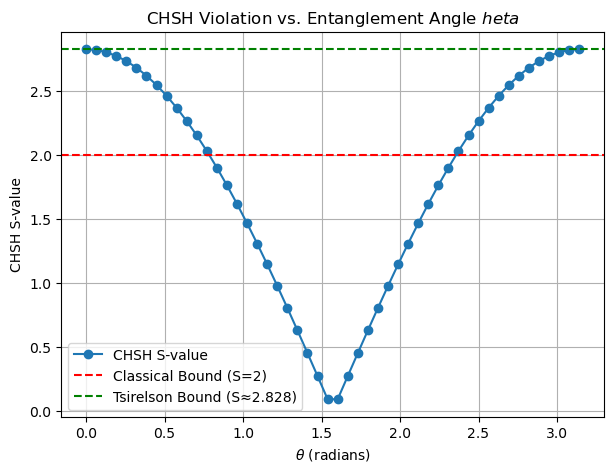

In [49]:
##############################################################################
# Create Parameterized Entangled State, quantum circuit, create a bell state
# and then apply parametrized ry(theta) to one qubit
##############################################################################
def create_entangled_state(theta):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    qc.ry(theta, 0)
    return qc
    
##############################################################################
# Measure Correlation <Z Z> after Local Rotations --> returns a real number 
# between +1 and -1 that indicates how correlated (positively or negatively) 
# the two qubits are when measured in the chosen local bases
##############################################################################
def measure_correlation(state, angle_qubit_0, angle_qubit_1):
    """
    `angle_qubit_0` and `angle_qubit_1`
    correspond to rotations about the Y-axis before measuring Z,
    effectively letting us measure along different axes
    """
    # Define R_y(angle) manually as a 2x2 matrix
    # R_y(angle) = [[cos(angle/2), -sin(angle/2)],
    #               [sin(angle/2),  cos(angle/2)]]
    rotation_0 = Operator([
        [np.cos(angle_qubit_0/2), -np.sin(angle_qubit_0/2)],
        [np.sin(angle_qubit_0/2),  np.cos(angle_qubit_0/2)]
    ])
    rotation_1 = Operator([
        [np.cos(angle_qubit_1/2), -np.sin(angle_qubit_1/2)],
        [np.sin(angle_qubit_1/2),  np.cos(angle_qubit_1/2)]
    ])
    
    # Apply local R_y rotations
    rotated_state = state.evolve(rotation_0, [0]).evolve(rotation_1, [1])
    
    # Use Pauli('ZZ') to measure Z \otimes Z on the rotated state
    correlation = np.real(rotated_state.expectation_value(Pauli('ZZ')))
    return correlation

##############################################################################
# 3. Compute the CHSH S-value
##############################################################################
def chsh_s_value(state, angles):
    """
    Given a quantum state and a dictionary of angles:
      angles = {
          'A1': float,
          'A2': float,
          'B1': float,
          'B2': float
      }
    measure:
       S = | <A1 B1> + <A1 B2> + <A2 B1> - <A2 B2> |
    where <A1 B1> means the correlation <Z Z> 
    after rotating each qubit by A1, B1.
    """
    A1B1 = measure_correlation(state, angles['A1'], angles['B1'])
    A1B2 = measure_correlation(state, angles['A1'], angles['B2'])
    A2B1 = measure_correlation(state, angles['A2'], angles['B1'])
    A2B2 = measure_correlation(state, angles['A2'], angles['B2'])
    S = np.abs(A1B1 + A1B2 + A2B1 - A2B2)
    return S

##############################################################################
# Choose measurement angles (canonical choice for maximum violation)
# Typically, the optimal CHSH angles for a singlet-like Bell state are:
# A1 = 0, A2 = pi/2, B1 = pi/4, B2 = -pi/4 (or a close variant).
# Each entangled state has its own set of optimal CHSH angles, 
# so you can tweak them as needed.
##############################################################################
angles = {
    'A1': 0.0,
    'A2': np.pi / 2,
    'B1': np.pi / 4,
    'B2': -np.pi / 4
}

thetas = np.linspace(0, np.pi, 50)
circuits = []
theta_labels = []

# Use the statevector simulator
backend = Aer.get_backend('statevector_simulator')

# Build circuits
for i, theta in enumerate(thetas):
    qc = create_entangled_state(theta)
    # unique circuit name to avoid collisions, idk i had a bunch of errors so i had to implrmrnt this, im sure you can get around it aswell
    qc.name = f"theta_{i}_{uuid.uuid4()}"  
    
    # Provide a unique label for saving the statevector
    qc.save_statevector(label=f"my_sv_{i}")

    circuits.append(qc)
    theta_labels.append(theta)

# Transpile
transpiled_circuits = transpile(circuits, backend=backend)

# Run
job = backend.run(transpiled_circuits)
result = job.result()

# Extract S-values
s_vals = []
for i, theta in enumerate(theta_labels):
    # Retrieve circuit name
    qc_name = transpiled_circuits[i].name
    
    # Retrieve dictionary containing data for this circuit
    data_dict = result.data(qc_name)
    
    # Extract the statevector from our unique label
    state_vector = data_dict[f"my_sv_{i}"]
    
    # Convert to a Statevector object
    state = Statevector(state_vector)
    
    # Compute CHSH S-value
    S = chsh_s_value(state, angles)
    s_vals.append(S)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(thetas, s_vals, 'o-', label='CHSH S-value')
plt.axhline(y=2, color='r', linestyle='--', label='Classical Bound (S=2)')
plt.axhline(y=2.828, color='g', linestyle='--', label='Tsirelson Bound (S≈2.828)')
plt.xlabel(r'$theta$ (radians)')
plt.ylabel('CHSH S-value')
plt.title('CHSH Violation vs. Entanglement Angle $\theta$')
plt.legend()
plt.grid(True)
plt.savefig('CHSH_violation_plot.png')
plt.show()